# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
#import libs 
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
from glob import glob


from PIL import ImageFile
import torch.optim as optim


In [2]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


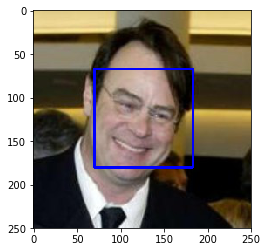

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0


### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

the human percentages images = 98.0%

the doges percentages images =17.0%


In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 

houman_count=0
dogs_count=0
for i in range (len(human_files_short)):
    if face_detector(human_files_short[i]):
        houman_count+=1
    if face_detector(dog_files_short[i]):
        dogs_count+=1
        
print("the human percentages images = {}%".format((houman_count/100)*100))
print("the doges percentages images ={}%".format((dogs_count/100)*100))

## on the images in human_files_short and dog_files_short.


the human percentages images = 98.0%
the doges percentages images =17.0%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [7]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:26<00:00, 21022818.42it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    imgs=Image.open(img_path)
    image_size=256
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))      
    ])
    
    img_pat=transform(imgs)
    img_batch=img_pat.unsqueeze(0)
    
    VGG16.eval()
    if use_cuda:
        img_batch = img_batch.cuda()
    output = VGG16(img_batch)
    output = output.cpu().data.numpy().argmax()
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    return output # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    ind=VGG16_predict(img_path)
    
    if (ind>=151)and(ind<=268):
        return True
    else:        
        return False # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

percentage of the images in `human_files_short` = 0.0%

percentage of the images in `dog_files_short`  =100.0%

In [9]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
houman_count=0
dogs_count=0


for i in human_files_short:
    if dog_detector(i):
        houman_count+=1
        
        
        
for i in dog_files_short:
    if dog_detector(i):
        dogs_count+=1
        
print("percentage of the images in `human_files_short` = {}%".format((houman_count/100)*100))
print("percentage of the images in `dog_files_short`  ={}%".format((dogs_count/100)*100))

## on the images in human_files_short and dog_


percentage of the images in `human_files_short` = 0.0%
percentage of the images in `dog_files_short`  =100.0%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [12]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [10]:
import os
from torchvision import datasets
from PIL import *

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes


                                              
transformer = {'train': transforms.Compose([
                                     transforms.Resize(256),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(30),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]),
                   
                   'valid': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]),
                   
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
                  }
    


batch_sizes=20
numofwork=0


training_data = datasets.ImageFolder('/data/dog_images/train', transform = transformer['train'])
testing_data = datasets.ImageFolder('/data/dog_images/test',transform =transformer['test'])
validation_data = datasets.ImageFolder('/data/dog_images/valid',transform =transformer['valid'])



train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_sizes,shuffle=True, num_workers=numofwork)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_sizes,shuffle=False ,num_workers=numofwork)
valid_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_sizes, shuffle=False, num_workers=numofwork)



**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
my  tensor shape is  224*224 and this cropping will lead to reducing the size of each image using cropping the edges 

and yes, I augmented my data using transformation module  

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        
        self.pool = nn.MaxPool2d(2, 2)


        self.fc1 = nn.Linear(28 * 28 * 64, 500)

        self.fc2 = nn.Linear(500, len(training_data.classes))
        self.dropout = nn.Dropout(0.25)
        self.batch_norm = nn.BatchNorm1d(num_features=500)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.batch_norm( self.fc1(x)) )
        x = self.dropout(x)
        x = self.fc2(x)
        return x
#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    
model_scratch

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
  (batch_norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
first, we loaded the dataset and separate it into 3 datasets "training, testing and validation" we augmented the dataset using transformation

 in the CNN architecture contain 3 Convnet layers and 2 linear layers to increase the depth, pooling layer to reduce the size,  after fully connected layer we puted 3 layers with relu activation function 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [13]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch =  nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [14]:
loaders_scratch = {'train' : train_loader,
                   'valid' : valid_loader,
                   'test' : test_loader}

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, train_loader, test_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target)
            loss.backward()
            
            
            optimizer.step()
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            
            
            valid_loss += loss.item()*data.size(0)
        valid_loss = valid_loss/len(valid_loader.dataset)    
        train_loss = train_loss/len(train_loader.dataset)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Valid loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


# train the model
model_scratch = train(40, train_loader, valid_loader, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.811292 	Validation Loss: 4.695720
Valid loss decreased (inf --> 4.695720).  Saving model ...
Epoch: 2 	Training Loss: 4.657231 	Validation Loss: 4.583092
Valid loss decreased (4.695720 --> 4.583092).  Saving model ...
Epoch: 3 	Training Loss: 4.554278 	Validation Loss: 4.493814
Valid loss decreased (4.583092 --> 4.493814).  Saving model ...
Epoch: 4 	Training Loss: 4.484959 	Validation Loss: 4.407944
Valid loss decreased (4.493814 --> 4.407944).  Saving model ...
Epoch: 5 	Training Loss: 4.417688 	Validation Loss: 4.333766
Valid loss decreased (4.407944 --> 4.333766).  Saving model ...
Epoch: 6 	Training Loss: 4.377826 	Validation Loss: 4.297792
Valid loss decreased (4.333766 --> 4.297792).  Saving model ...
Epoch: 7 	Training Loss: 4.338887 	Validation Loss: 4.221856
Valid loss decreased (4.297792 --> 4.221856).  Saving model ...
Epoch: 8 	Training Loss: 4.292063 	Validation Loss: 4.263490
Epoch: 9 	Training Loss: 4.253408 	Validation Loss: 4.157303
Valid lo

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [15]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(test_loader, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.514483


Test Accuracy: 17% (145/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [10]:
## TODO: Specify data loaders
batch_size = 20

                                              
transformer = {'train': transforms.Compose([
                                     transforms.Resize(256),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(30),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]),
                   
                   'valid': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]),
                   
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
                  }
train_data = datasets.ImageFolder('/data/dog_images/train', transform = transformer['train'])

test_data = datasets.ImageFolder('/data/dog_images/test',transform=transformer['test'])
valid_data = datasets.ImageFolder('/data/dog_images/valid',transform=transformer['valid'])


loaders_transfer = {}
loaders_transfer['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
loaders_transfer['valid'] = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
loaders_transfer['test'] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


print ("number of training image" , len(train_data))
print ("number of validation image" , len(valid_data))
print ("number of testing image" , len(test_data))

number of training image 6680
number of validation image 835
number of testing image 836


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [11]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 


model_transfer = models.resnet50(pretrained = True)

for param in model_transfer.parameters():
    param.requires_grad = False

n_input = model_transfer.fc.in_features
n_output = model_transfer.fc.out_features


model_transfer.fc = nn.Linear(n_input, len(train_data.classes))
                           
    
if use_cuda:
    model_transfer = model_transfer.cuda()
    
print("model_transfer is ",model_transfer)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 91792478.03it/s]


model_transfer is  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), st

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

first, we loaded the previous data to use it and create transfer learning using resnet50

because the data is similar therefore most pre-trained network will already contain relevant wights about the dataset  


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [30]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(),lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [31]:
# train the model
ImageFile.LOAD_TRUNCATED_IMAGES = True
n_epochs = 10


model_transfer = train(n_epochs, loaders_transfer['train'],loaders_transfer['test'], model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 8.672852 	Validation Loss: 5.267935
Valid loss decreased (inf --> 5.267935).  Saving model ...
Epoch: 2 	Training Loss: 6.912106 	Validation Loss: 4.927926
Valid loss decreased (5.267935 --> 4.927926).  Saving model ...
Epoch: 3 	Training Loss: 7.385103 	Validation Loss: 5.161122
Epoch: 4 	Training Loss: 7.287096 	Validation Loss: 4.773240
Valid loss decreased (4.927926 --> 4.773240).  Saving model ...
Epoch: 5 	Training Loss: 7.606712 	Validation Loss: 4.835031
Epoch: 6 	Training Loss: 7.628796 	Validation Loss: 5.369403
Epoch: 7 	Training Loss: 8.053106 	Validation Loss: 5.099616
Epoch: 8 	Training Loss: 7.767788 	Validation Loss: 5.396674
Epoch: 9 	Training Loss: 7.678768 	Validation Loss: 4.293033
Valid loss decreased (4.773240 --> 4.293033).  Saving model ...
Epoch: 10 	Training Loss: 7.756052 	Validation Loss: 4.374334


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [32]:
test(loaders_transfer['test'], model_transfer, criterion_transfer, use_cuda)

Test Loss: 3.694342


Test Accuracy: 72% (608/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [12]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
ImageFile.LOAD_TRUNCATED_IMAGES = True

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in test_data.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    images = Image.open(img_path).convert('RGB')

    
 
    img_tensor = transformer['test'](images)[:3,:,:].unsqueeze(0)
        
    if torch.cuda.is_available():
        img_tensor = img_tensor.cuda()
        with torch.no_grad():
                model_transfer.eval()
    output = model_transfer(img_tensor)
    
    prediction = torch.argmax(output).item()
        
    print('Number of dog detected:', len(output))

    return class_names[prediction]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [13]:
def display_image(img_path):
    image = Image.open(img_path)
    plt.imshow(image)
    plt.show()

In [14]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    
      
    if face_detector(img_path):      
        print("this is a Hunman ,Hello Hunman ",predict_breed_transfer(img_path))
        # dispay the image, along with bounding box
        display_image(img_path)
    elif  dog_detector(img_path):      
        print("this is a Dog , Nice day dog",predict_breed_transfer(img_path))
        # display the image, along with bounding box
        display_image(img_path)

    else:
        print("There is no hunam or dog here ")
        display_image(img_path)
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
the output is better than you expected but we can improve it more and more 

we should first increase the number of epochs because it's very little 

we can add more Convnets for better classifying 

we can try to use another pre-train models for a better accuracy 

Number of dog detected: 1
this is a Hunman ,Hello Hunman  Pembroke welsh corgi


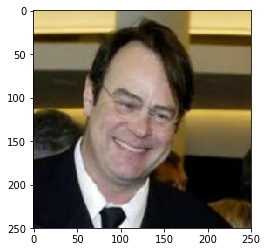

Number of dog detected: 1
this is a Hunman ,Hello Hunman  Akita


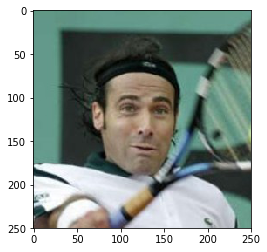

Number of dog detected: 1
this is a Hunman ,Hello Hunman  Norwegian lundehund


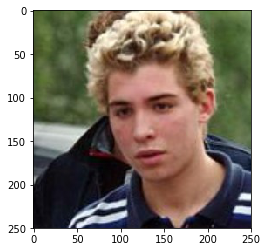

Number of dog detected: 1
this is a Hunman ,Hello Hunman  Italian greyhound


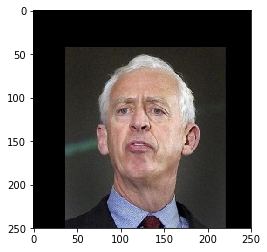

Number of dog detected: 1
this is a Dog , Nice day dog German wirehaired pointer


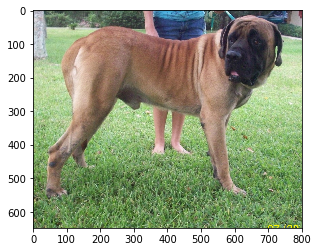

Number of dog detected: 1
this is a Dog , Nice day dog Norwegian buhund


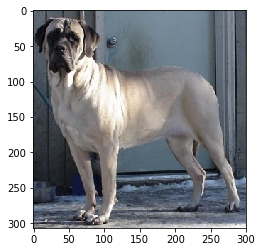

Number of dog detected: 1
this is a Dog , Nice day dog Flat-coated retriever


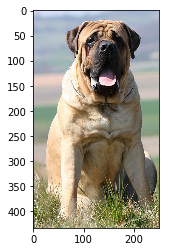

Number of dog detected: 1
this is a Dog , Nice day dog Norwegian buhund


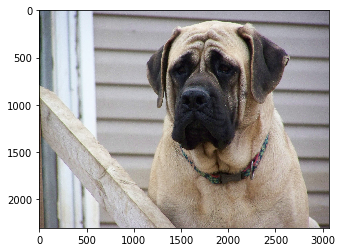

In [15]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.



## suggested code, below

for file in np.hstack((human_files[:4], dog_files[:4])):
    run_app(file)

In [ ]:
https://viewjz0ral44olo.udacity-student-workspaces.com/view/dog_project/images/images%20(1).jpg

Number of dog detected: 1
this is a Hunman ,Hello Hunman  Black russian terrier


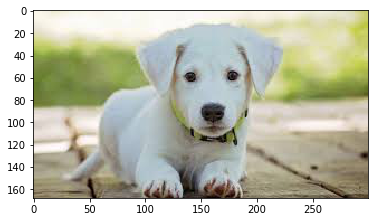

Number of dog detected: 1
this is a Dog , Nice day dog Norwegian lundehund


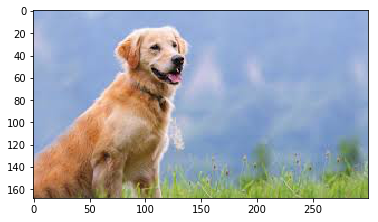

Number of dog detected: 1
this is a Dog , Nice day dog Manchester terrier


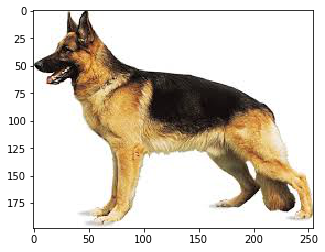

Number of dog detected: 1
this is a Hunman ,Hello Hunman  Collie


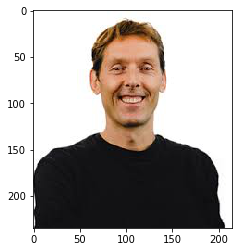

Number of dog detected: 1
this is a Hunman ,Hello Hunman  Collie


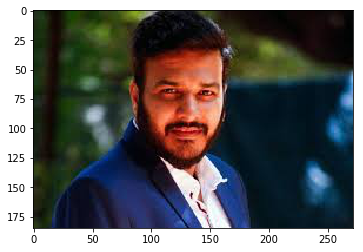

Number of dog detected: 1
this is a Hunman ,Hello Hunman  Black russian terrier


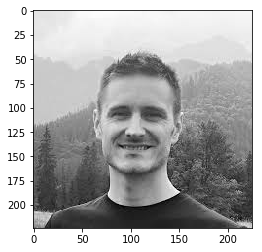

In [64]:
img='images/images(0).jpg'
im3='images/i.jpg'
im4='images/im.jpg'
im5='images/ima.jpg'
im6='images/imag.jpg'
im2='images/dog.jpg'
run_app(im2)
run_app(img)
run_app(im3)
run_app(im4)
run_app(im5)
run_app(im6)